In [1]:
!python --version
!java --version

Python 3.7.10
openjdk 11.0.10 2021-01-19
OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)


**Install necessary packages**

In [2]:
! pip install transformers   

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**imports**

In [4]:
import os 
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [5]:
import tensorflow as tf
print (tf.__version__)
tf.get_logger().setLevel('ERROR')

import pprint

2.4.1


In [6]:
import locale
from time import time
import datetime
import gc
import unicodedata 
import math
import random
import pprint

import numpy as np
import pandas as pd

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.models import Model
from tensorflow.keras import layers

from tensorflow.keras.utils import plot_model
import tensorflow.keras.backend as KBEND

In [8]:
#import nltk
#nltk.download('punkt')
#from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
#from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import TFBertModel, BertConfig, BertTokenizerFast , BertTokenizer

In [9]:
import re  # regular expressions
import pickle
#from stop_words import get_stop_words

from sklearn import model_selection, preprocessing, metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold 
from sklearn.metrics import confusion_matrix

import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import gridspec  
from matplotlib.ticker import FuncFormatter 

from IPython.display import display
from ipywidgets import FloatProgress

#Windows
#prefix = 'E:'
#Linux
#prefix = '/media/kyazigee/Samsung_T5_PC'
#Google drive
prefix = 'drive/MyDrive'

data_dir = prefix + '/WORK/HCI/AirBank/TVT/'
data_dir_tokenized = prefix + '/WORK/HCI/AirBank/TVT/TokenizedTrainTest/'
BERT_dir = prefix + '/WORK/HCI/AirBank/TVT/BERT/'
DCNN_dir = prefix + '/WORK/HCI/AirBank/TVT/DCNN/'

**Load Pretrained BErtmodel**

In [10]:
BERT_dir = prefix + '/WORK/HCI/AirBank/TVT/BERT/'
modelsFolder = BERT_dir + 'bert-base-bg-cs-pl-ru-cased/'
#tokenizer
bert_tokenizer = BertTokenizerFast.from_pretrained(modelsFolder)
# pretrained model
SLAVICBERT = TFBertModel.from_pretrained(modelsFolder, from_pt=True)
SLAVICBERT.save_weights(DCNN_dir  + 'SLAVICBERT.h5', overwrite = True, save_format='h5')
configuration = SLAVICBERT.config

All PyTorch model weights were used when initializing TFBertModel.

All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [11]:
config = BertConfig.from_pretrained(modelsFolder, output_attentions=True) 
configuration.__dict__['output_attentions'] = True
model = TFBertModel(configuration)

**Demo (cosine similarity between two sentences)**

In [12]:
max_seq_length = 50

veta1 = 'Bolí mně hlava'
veta2 = 'Odsuzujete slušného člověka bez jediného důkazu'

#------
x = bert_tokenizer(veta1 , max_length = max_seq_length, padding= 'do_not_pad',truncation= True,
                                   return_token_type_ids = False,
                                   return_attention_mask = True,
                                   return_tensors = 'tf')
input_ids = x.input_ids.numpy()[0]
attn_mask = x.attention_mask.numpy()[0]

OUTPUT = model(input_ids = np.expand_dims(input_ids, 0), attention_mask = np.expand_dims(attn_mask, 0), return_dict = True)
#print(OUTPUT.keys())
veta1_PooledAVG = layers.GlobalAveragePooling1D()(OUTPUT['last_hidden_state'])
veta1_CLS = OUTPUT['pooler_output']


#--------
x = bert_tokenizer(veta2 , max_length = max_seq_length, padding= 'do_not_pad',truncation= True,
                                   return_token_type_ids = False,
                                   return_attention_mask = True,
                                   return_tensors = 'tf')
input_ids = x.input_ids.numpy()[0]
attn_mask = x.attention_mask.numpy()[0]

OUTPUT = model(input_ids = np.expand_dims(input_ids, 0), attention_mask = np.expand_dims(attn_mask, 0), return_dict = True)
veta2_PooledAVG = layers.GlobalAveragePooling1D()(OUTPUT['last_hidden_state'])
veta2_CLS = OUTPUT['pooler_output']
#attention_filter = OUTPUT['attentions']
#----------

metric = tf.keras.metrics.CosineSimilarity(axis = -1)
metric.reset_states()
metric.update_state(veta1_PooledAVG, veta2_PooledAVG)
#metric.update_state(veta1_CLS, veta2_CLS)
metric.result().numpy()


0.89439976

**Display attention mask of heads of last layer**

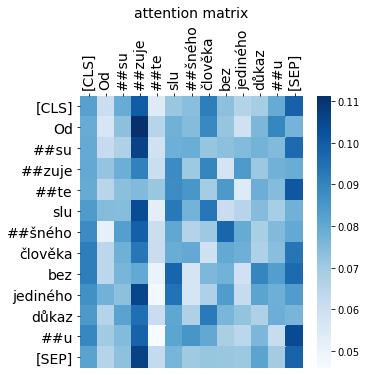

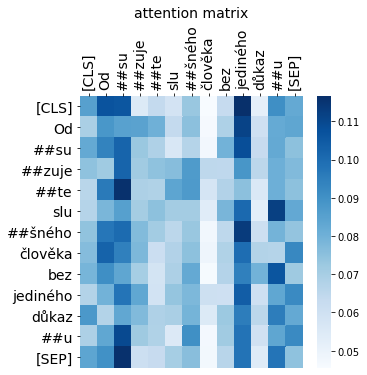

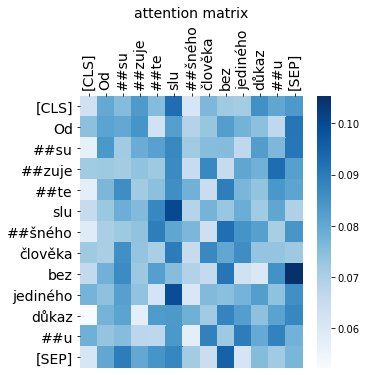

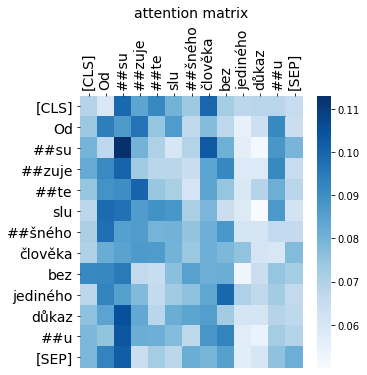

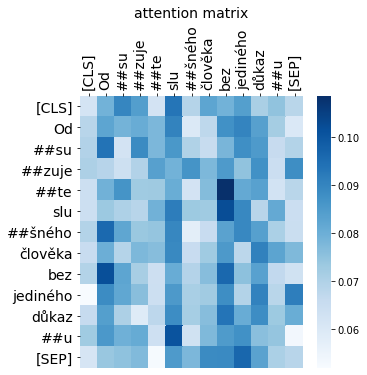

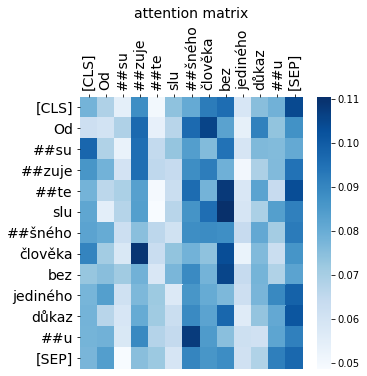

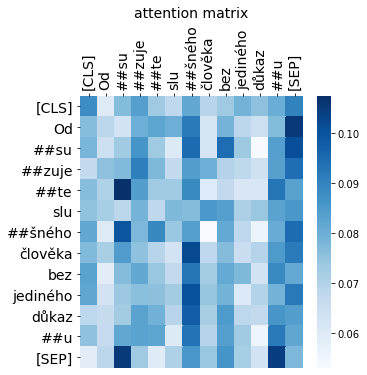

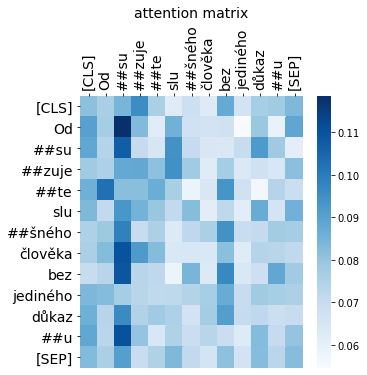

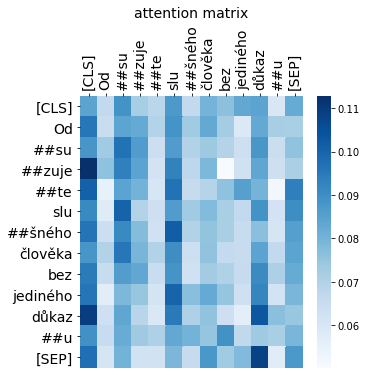

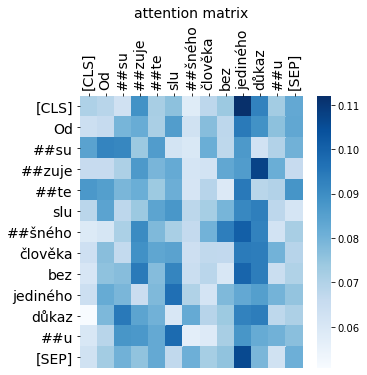

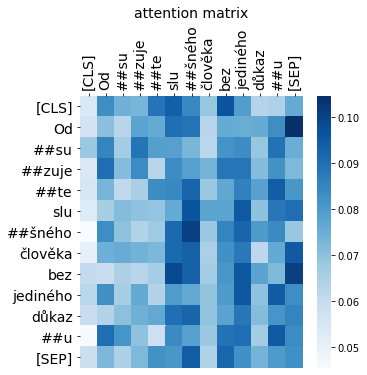

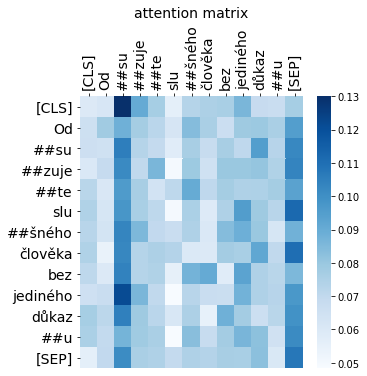

In [13]:
attention_filter = OUTPUT['attentions']

batch =  0 #row index is test

for head in range(12):

  layer = 11
  att = attention_filter[layer][batch][head].numpy()

  last = 0
  colnames = []
  for col in bert_tokenizer.convert_ids_to_tokens(input_ids, skip_special_tokens =False):
    colnames.append(col)
    if col != '[PAD]':
      last+=1

  fig, ax = plt.subplots(figsize = (5,5))
  ax.set_title('attention matrix', fontsize = 14)
  ax = sns.heatmap(att[0:last, 0:last] , 
                  annot = False, 
                  xticklabels=colnames[0:last], 
                  yticklabels = colnames[0:last],
                  fmt = ".0%", 
                  cmap = "Blues",)
  ax.tick_params(axis='x', labelsize=14, rotation = 90)
  ax.tick_params(axis='y', labelsize=14, rotation = 0)
  ax.xaxis.set_ticks_position('top')
  plt.show()